# Flow Matching Optimal Transport with OTT

This tutorial demonstrates how to use the [OTT](https://ott-jax.readthedocs.io/en/latest/) library's `OTFlowMatching` class for learning optimal transport maps between probability distributions using neural networks. 

**Flow Matching** is a recent approach to optimal transport that leverages neural ODEs and velocity fields to learn mappings between source and target distributions in a scalable and flexible way. The OTT library provides efficient and modular tools for implementing these methods in JAX.

In this notebook, you will learn how to:
- Generate synthetic datasets for source and target distributions.
- Set up and train a neural flow matching model using OTT's `OTFlowMatching`.
- Visualize the learned transport map and analyze the results.


This tutorial is intended for users who want to get started with neural optimal transport using OTT and understand the practical workflow for flow matching models.

## Setup and Helper Functions

We begin by importing required libraries and defining helper functions. These include data loaders for synthetic distributions as well as visualization routines that plot the source and transported distributions. In addition, we define functions to generate synthetic batches and compute pairwise distances used for matching.

In [18]:
import jax
import jax.numpy as jnp
import numpy as np
import optax
import matplotlib.pyplot as plt
import time
from ott import datasets
from ott.neural.networks.velocity_field import VelocityField
from ott.neural.methods.flows.otfm import OTFlowMatching
from ott.neural.methods.flows.dynamics import ConstantNoiseFlow
from ott.solvers import utils as solver_utils

## Data Generation and Visualization

We use synthetic data to simulate source and target distributions. For example, the source samples and target samples can be drawn uniformly from a 2-D space. In each batch, the source and target are paired along with their corresponding conditions.

We then visualize the initial distributions to understand the problem setting before training the model.

In [19]:
def loader_from_dataset(ds, n_batches):
    for _ in range(n_batches):
        src = next(ds.source_iter)
        tgt = next(ds.target_iter)
        tgt_mod = tgt  # Modify target distribution if needed
        yield {"src_lin": src, "tgt_lin": tgt_mod, "src_condition": src}

def plot_initial(source, target, title="Initial Distributions"):
    plt.figure(figsize=(6,6))
    plt.scatter(source[:, 0], source[:, 1], c="blue", label="Source", alpha=0.6)
    plt.scatter(target[:, 0], target[:, 1], c="green", label="Target", alpha=0.6)
    plt.xlabel("x")
    plt.ylabel("y")
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()

def plot_transport(source, transported, title="Flow Matching Transport"):
    plt.figure(figsize=(6,6))
    plt.scatter(source[:, 0], source[:, 1], c="blue", label="Source", alpha=0.6)
    plt.scatter(transported[:, 0], transported[:, 1], c="red", label="Transported", alpha=0.6)
    for i in range(source.shape[0]):
        plt.arrow(
            source[i, 0],
            source[i, 1],
            transported[i, 0] - source[i, 0],
            transported[i, 1] - source[i, 1],
            head_width=0.02, head_length=0.03, fc='gray', ec='gray', alpha=0.5
        )
    plt.xlabel("x")
    plt.ylabel("y")
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()

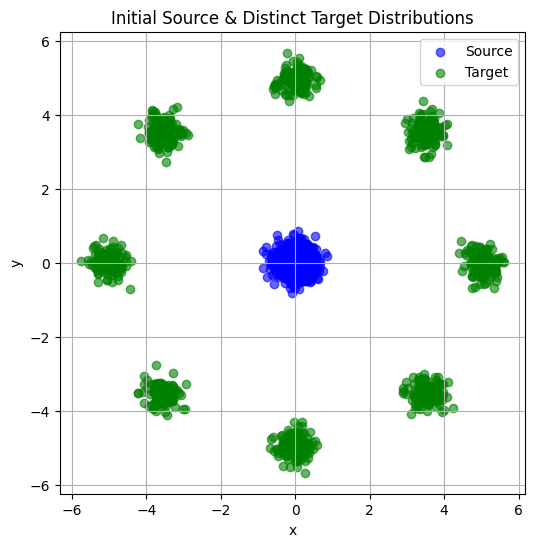

In [20]:
num_samples_visualize = 1000
(train_dataloaders, valid_dataloaders, input_dim) = datasets.create_gaussian_mixture_samplers(
    name_source="simple",
    name_target="circle",
    train_batch_size=num_samples_visualize,
    valid_batch_size=num_samples_visualize,
)

valid_source = next(valid_dataloaders.source_iter)
valid_target = next(valid_dataloaders.target_iter)
valid_target_mod = valid_target
plot_initial(valid_source, valid_target_mod, title="Initial Source & Distinct Target Distributions")

## Model Setup

The Flow Matching OT model consists of:
- A **Velocity Field (vf):** Implemented as a neural network that learns the transport dynamics.
- A **Flow Component:** For instance, a constant noise flow (with a specified sigma) to simulate the propagation of samples in the latent domain.
- An **Optimal Transport Matching Function:** Based on entropic regularization, it computes soft assignments between source and target. The matching function is derived from the negative Euclidean distance, ensuring that closer pairs receive higher matching scores.

An optimizer (e.g., ADAM) is used to initialize the training process, and a random seed is set for reproducibility.

In [21]:
vf = VelocityField(hidden_dims=[128, 128, 128], output_dims=[2])
flow = ConstantNoiseFlow(sigma=0.1)
optimizer = optax.adabelief(1e-3)
rng_init = jax.random.PRNGKey(0)

ot_flow_matching = OTFlowMatching(
    vf, flow, time_sampler=solver_utils.uniform_sampler,
    rng=rng_init, optimizer=optimizer
)

## Training the Model

The training loop consists of multiple epochs. For each epoch:

1. **Data Loading:** The model iterates over batches provided by the synthetic data loader.
2. **Contrastive Representation Learning:** The model encodes modalities into a shared latent space where corresponding source and target samples are aligned.
3. **Optimal Transport Matching:** The embedded representations are soft-matched using the entropic optimal transport module.
4. **Loss Computation and Backpropagation:** A mean-squared error loss is computed between the predicted dynamics and target values, and the model parameters are updated via backpropagation.

Training logs are maintained to record the loss at each iteration, and average epoch losses are reported to monitor convergence.

In [23]:

n_train_batches = 1000 # How much of the dataset to use for training
n_iters = n_train_batches # Number of iterations before flow matching stops training (here we wan to train over the entire dataset)

rng = jax.random.PRNGKey(int(time.time()))
train_loader = loader_from_dataset(train_dataloaders, n_train_batches)
logs = ot_flow_matching(train_loader, n_iters=n_iters, rng=rng)

## Evaluation and Visualization

After training, we evaluate the learned transport plan by applying the model to a test dataset. The `transport` function integrates the learned flow using a neural ODE solver.

The results are visualized by plotting:
- **Source Distribution:** Displayed in blue.
- **Transported Distribution:** Displayed in red.
- **Flow Arrows:** Illustrating the movement from original to transported points.

These visual comparisons allow us to assess how well the model has learned to match the source distribution to the target.

Original test data (first 5 rows):
[[ 0.12216712  0.03956028]
 [-0.04882848  0.5526268 ]
 [-0.28353128  0.02702082]
 [ 0.15719321 -0.50066674]
 [ 0.20921074 -0.03818622]]
Transported test data (first 5 rows):
[[ 4.532891    0.14506328]
 [-0.11823785  5.5591497 ]
 [-5.0186663   0.11204083]
 [ 0.40515357 -5.352594  ]
 [ 4.903796   -0.33851117]]


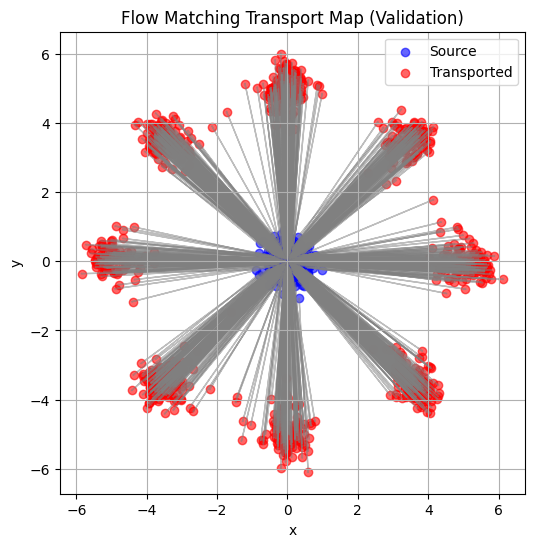

In [ ]:
valid_source = next(valid_dataloaders.source_iter)
valid_target = next(valid_dataloaders.target_iter)
valid_target_mod = valid_target

test_data = jnp.asarray(valid_source)
transported = ot_flow_matching.transport(test_data, t0=0.0, t1=1.0) # we can view how far the flow has transported the data by modifying the t0 and t1 parameters

print("Original test data (first 5 rows):")
print(test_data[:5])
print("Transported test data (first 5 rows):")
print(transported[:5])

source_np = np.array(test_data)
transported_np = np.array(transported)
plot_transport(source_np, transported_np, title="Flow Matching Transport Map (Validation)")

## Adding epochs

If the qualitative result is not satisfactory, we can opt to further train the model if the resources and time are available. Quantitatively, results might not improve much but qualitatively there may be an improvement.

In [26]:
n_epochs = 5
n_train_batches = 1000
n_iters_per_epoch = n_train_batches

all_losses = []

for epoch in range(n_epochs):
    print(f"Epoch {epoch + 1}/{n_epochs}")
    rng = jax.random.PRNGKey(int(time.time()))
    train_loader = loader_from_dataset(train_dataloaders, n_train_batches)
    logs = ot_flow_matching(train_loader, n_iters=n_iters_per_epoch, rng=rng)
    epoch_loss = logs["loss"]
    all_losses.extend(epoch_loss)
    print(f"Average loss for epoch {epoch + 1}: {np.mean(epoch_loss):.4f}")

print("Total training done. Final loss:", all_losses[-1])

Epoch 1/5
Average loss for epoch 1: 1.3247
Epoch 2/5
Average loss for epoch 2: 1.3203
Epoch 3/5
Average loss for epoch 3: 1.3256
Epoch 4/5
Average loss for epoch 4: 1.3189
Epoch 5/5
Average loss for epoch 5: 1.3287
Total training done. Final loss: 1.2368401288986206


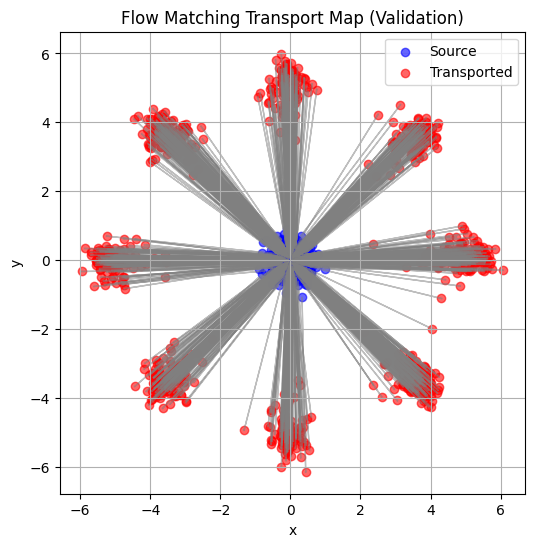

In [27]:
transported = ot_flow_matching.transport(test_data, t0=0.0, t1=1.0)
transported_np = np.array(transported)
plot_transport(source_np, transported_np, title="Flow Matching Transport Map (Validation)")

Visualize transport map on a subset of the data, focusing on points with the largest x-coordinate for a better zoom.

play around with the subset size to visualize different parts of the transport map


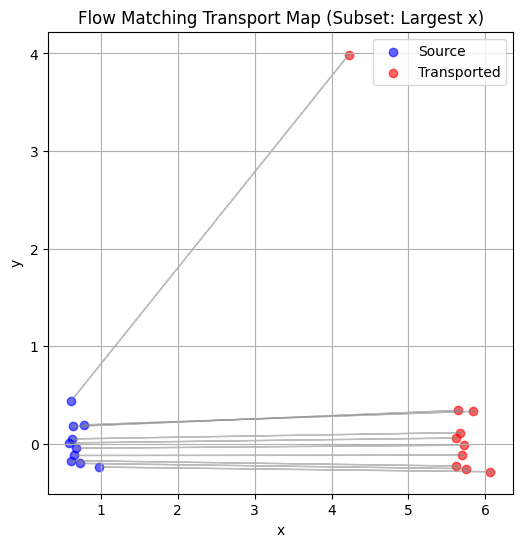

In [ ]:
# Visualize transport map on a subset of the data, focusing on points with the largest x-coordinate for a better zoom

def visualize_transport_map_subset(source, transported, subset_size=100):
    # Select indices of the points with the largest x (first column)
    indices = np.argsort(source[:, 0])[-subset_size:]
    subset_source = source[indices]
    subset_transported = transported[indices]

    plt.figure(figsize=(6, 6))
    plt.scatter(subset_source[:, 0], subset_source[:, 1], c="blue", label="Source", alpha=0.6)
    plt.scatter(subset_transported[:, 0], subset_transported[:, 1], c="red", label="Transported", alpha=0.6)
    for i in range(subset_source.shape[0]):
        plt.arrow(
            subset_source[i, 0],
            subset_source[i, 1],
            subset_transported[i, 0] - subset_source[i, 0],
            subset_transported[i, 1] - subset_source[i, 1],
            head_width=0.02, head_length=0.03, fc='gray', ec='gray', alpha=0.5
        )
    plt.xlabel("x")
    plt.ylabel("y")
    plt.title("Flow Matching Transport Map (Subset: Largest x)")
    plt.legend()
    plt.grid(True)
    plt.show()

# play around with the subset size to visualize different parts of the transport map
visualize_transport_map_subset(source_np, transported_np, subset_size=10)